In [8]:
import ipykernel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
torch.set_printoptions(linewidth=120)

In [9]:
print(torch.__version__)
print(torchvision.__version__)

1.7.1
0.8.2


In [10]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [12]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)

In [15]:
tb = SummaryWriter()

network = Network()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()

In [8]:
sample = next(iter(train_set))
image,label = sample
network = Network()
out = network(image.unsqueeze(0))
print(out)

tensor([[-0.0491, -0.1288, -0.0595,  0.1061, -0.0580,  0.0913, -0.0133, -0.0772, -0.1173, -0.1316]],
       grad_fn=<AddmmBackward>)


In [15]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)


for epoch in range(5):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        images, labels = batch

        preds = network(images) # Pass Batch

        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds,labels)
    print(
        "epoch:", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch: 0 total_correct: 46585 loss: 353.3579144179821
epoch: 1 total_correct: 51424 loss: 234.50215850770473
epoch: 2 total_correct: 52191 loss: 213.548618003726
epoch: 3 total_correct: 52559 loss: 201.63066363334656
epoch: 4 total_correct: 52722 loss: 196.93229246139526


In [73]:
total_correct / len(train_set)

0.8716166666666667

In [18]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [19]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [20]:
train_preds.argmax(dim=1)
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [77]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 52008
accuracy: 0.8668


In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [79]:
stack = torch.stack((train_set.targets,train_preds.argmax(dim=1)),dim=1)

In [80]:
stack.shape

torch.Size([60000, 2])

In [81]:
cmt = torch.zeros(10,10,dtype = torch.int32)

In [82]:
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [83]:
for row in stack:
    truelabel,predictedlabel = row.tolist()
    cmt[truelabel][predictedlabel] += 1

In [111]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1) )

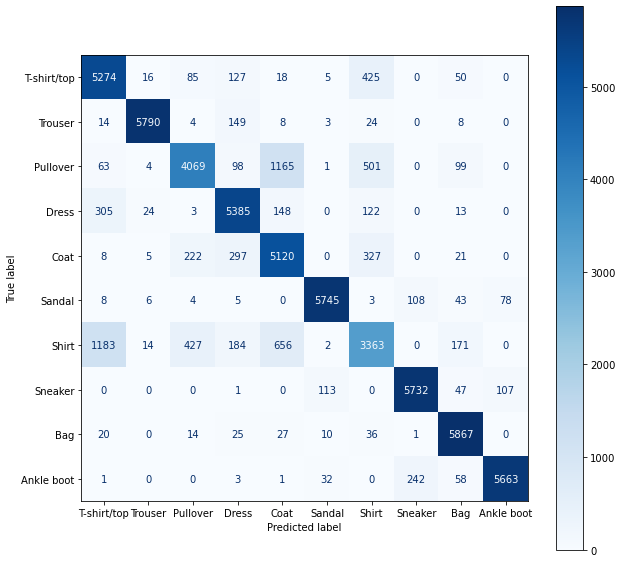

In [130]:
# plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=train_set.classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)

In [131]:
test_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [137]:
test_prediction_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)
test_preds = get_all_preds(network, test_prediction_loader)

In [138]:
test_preds_correct = get_num_correct(test_preds, test_set.targets)

print('total correct:', test_preds_correct)
print('accuracy:', test_preds_correct / len(test_set))

total correct: 8518
accuracy: 0.8518


In [139]:
test_cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1) )

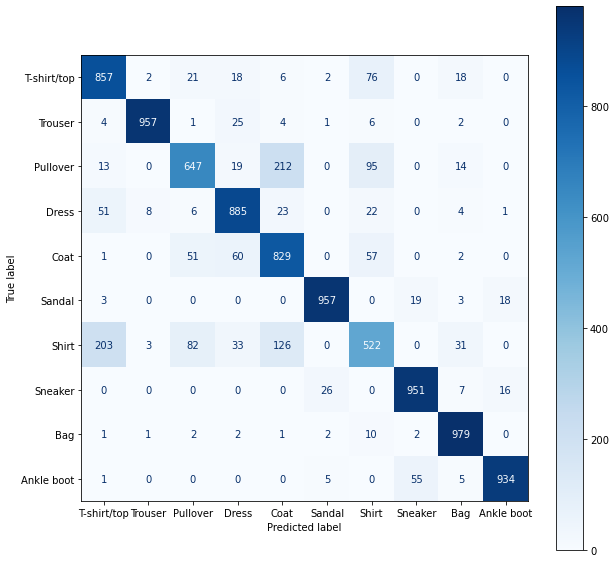

In [141]:
# plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm,display_labels=test_set.classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues)